# Chunking (*with an example using `scikit-image`*)

Many of the manipulations on distributed Bolt arrays use "chunking" under the hood to make operations like swapping and transposing more efficient. These chunked arrays are themselves useful for more fine-grained control over parallelization, so we expose them directly.

Let's start with a simple distributed array where the values have shape `(20,10)`

In [1]:
from bolt import ones

In [2]:
a = ones((2, 20, 10), sc)

In [3]:
a.shape

(2, 20, 10)

To `chunk`, we specify the size of chunks along each axis. Here we only provide two sizes, not three, because we can only chunk along the axes stored in the values (which in this case includes two axes).

In [4]:
a.values.shape

(20, 10)

In [5]:
c = a.chunk((10, 5))

To see what happened, let's look at the values of the underlying RDD. Whereas initially each value was a `(20,10)` array, when chunked each one is `(10,5)`

In [6]:
a.tordd().values().first().shape

(20, 10)

In [7]:
c.tordd().values().first().shape

(10, 5)

Let's also look at the keys. They are tuples, but instead of just indexing along the first axis, they now additionally index along the chunk. Note that we've gone from 2 records in total to 8 because each subarray was broken into 4 chunks, for a total of 2 * 4.

In [8]:
a.tordd().keys().collect()

[(0,), (1,)]

In [9]:
c.tordd().keys().collect()

[((0,), (0, 0)),
 ((0,), (0, 1)),
 ((0,), (1, 0)),
 ((0,), (1, 1)),
 ((1,), (0, 0)),
 ((1,), (0, 1)),
 ((1,), (1, 0)),
 ((1,), (1, 1))]

We can perform parallelized `map` operations on the `ChunkedArray` and then `unchunk` to get our transformed array back and usable in other operations. Shape changes are checked and automatically handled, though there are limitations on the kinds of functions that can be performed. Chunking followed by mapping is useful for distributing operations over arrays when it either inconvienient or inefficient to operate over entire axes.

In [10]:
c.map(lambda x: x * 2).unchunk().toarray().shape

(2, 20, 10)

In [11]:
c.map(lambda x: x[0:2,0:2]).unchunk().toarray().shape

(2, 4, 4)

Note that `map` is the **only** operation currently available on the `ChunkedArray`. This is because we need to carefully control and propogate shape information, and once an array is chunked it's more complex to handle the same full set of functions we provide on the core Bolt array. But we can definitely add new functionality to the `ChunkedArray` in the future, just let us know your use case!

## Image processing example

One common use case we imagine is performing parallelized operations over chunks of images. We we implement such an example using functions from ``scikit-image`` and example data from ``scikit-learn``.

First load the example images and store them as arrays

In [12]:
from sklearn import datasets
from numpy import asarray
imgs = datasets.load_sample_images()
im = asarray([imgs.images[0], imgs.images[1]])

Set up plotting

In [13]:
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt

In [15]:
from sklearn import datasets
from numpy import asarray

We'll write a small helper function that shows images nicely

In [16]:
def image(im):
    plt.figure(figsize=(10,7))
    plt.imshow(im, cmap='gray', interpolation='none');
    plt.axis('off')

Here's the first image

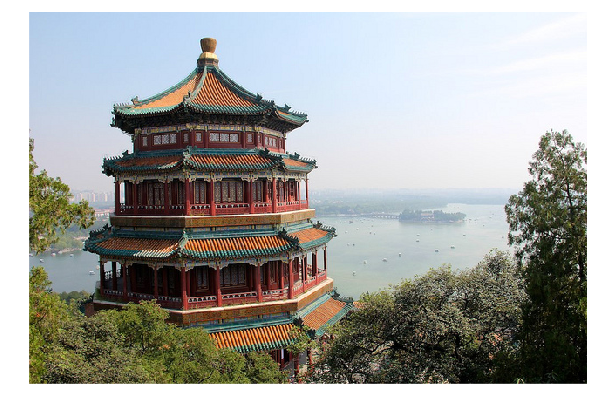

In [17]:
image(im[0])

Now build a Bolt array, parallelized along the first axis (so each record is one image)

In [18]:
from bolt import array

In [19]:
b = array(im, sc, axis=(0,))

We're going to crop our images (which we can do with simple slice indexing) to keep our chunking even

In [20]:
rgb = b[:,0:400,0:600,:]

In [21]:
rgb.values.shape

(400, 600, 3)

Now let's chunk along x and y (but not along the color channel)

In [22]:
chunks = rgb.chunk(size=(100,100,3))

Check that the shape of the first value is indeed an array of size `(100,100,3)`

In [23]:
chunks.tordd().values().first().shape

(100, 100, 3)

Apply a function that selects one channel (dropping the rest). This effectively converts from rgb to grayscale.

In [24]:
gray = chunks.map(lambda x: x[:,:,0]).unchunk().squeeze().toarray()

The total shape should now be missing the color dimension

In [25]:
gray.shape

(2, 400, 600)

Look at the first image

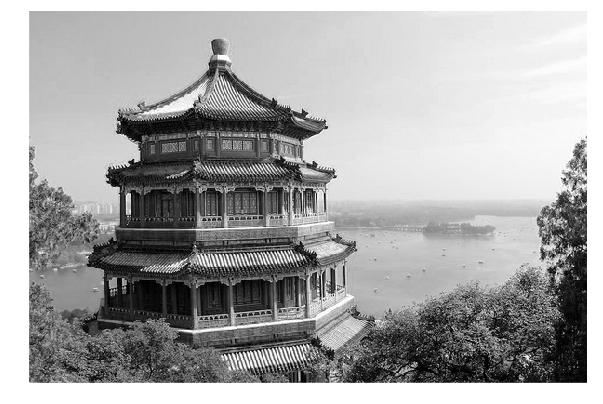

In [26]:
image(gray[0])

Remember we actually started by parallelizing over our two images? The conversion was applied exactly the same to the other image!

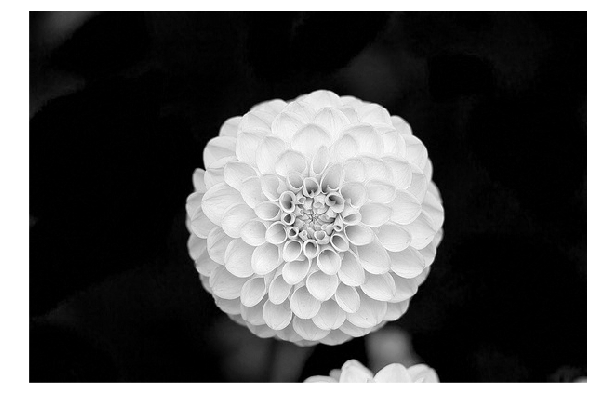

In [27]:
image(gray[1])

Now let's apply a more complex function from ``scikit-image``, median filtering each chunk

In [28]:
from skimage.filters.rank import median
from skimage.morphology import disk

In [29]:
filtered = chunks.map(lambda x: median(x[:,:,0], disk(20))).unchunk().squeeze().toarray()

Look at the images (and note the visible block structure, those are our chunks!)

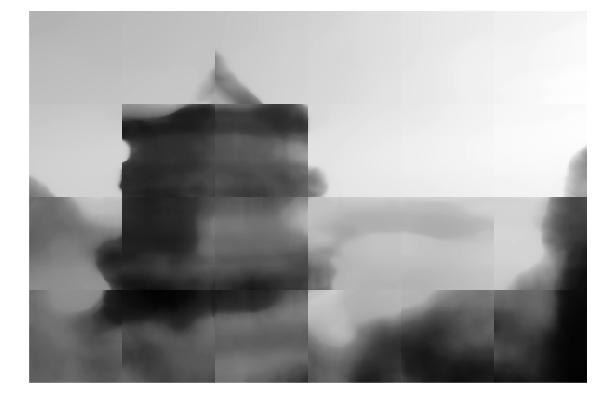

In [30]:
image(filtered[0])

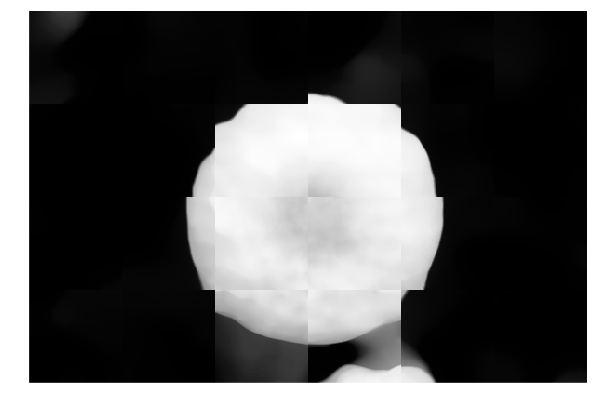

In [31]:
image(filtered[1])

Chunking is a powerful way to control how you operate over your distributed arrays in Bolt.